### Intro to Neural Networks


In [3]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import pandas as pd

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

### Toy dataset



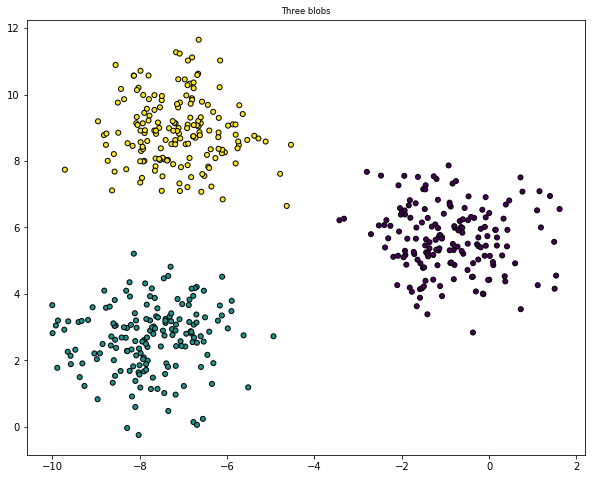

In [29]:
from sklearn.datasets import make_blobs
plt.title("Three blobs", fontsize='small')
X, y = make_blobs(n_samples = 500, n_features=2, centers=3)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

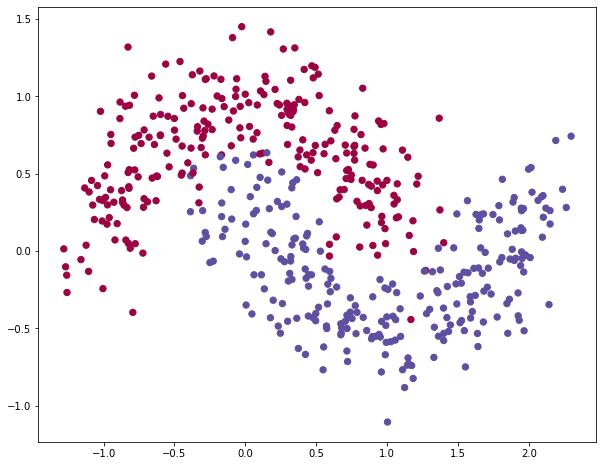

In [4]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(500, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

### Goal: To predict the class, given x. 

The data clearly isn't linearly separable. This means that linear classifiers, such as Logistic Regression, won't be able to fit the data unless you hand-engineer non-linear features (such as polynomials) that work well for the given dataset.

That's one of the major advantages of Neural Networks. You don't need to worry about feature engineering. The hidden layer of a neural network will learn features for you.

In [11]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Text(0.5, 1.0, 'Logistic Regression')

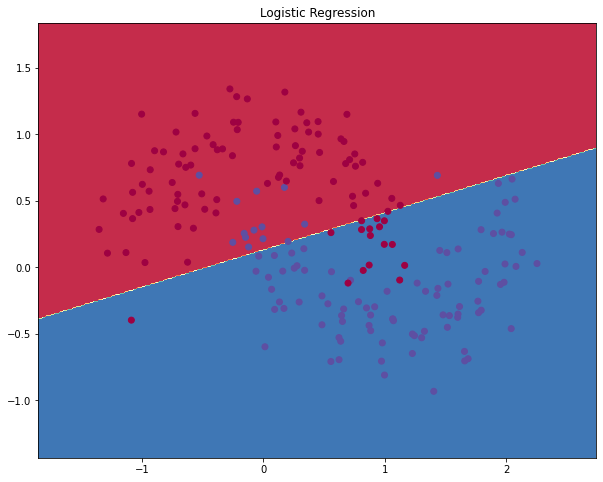

In [5]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

## How does our network makes predictions?


Our network makes predictions using *forward propagation*, which is just a bunch of matrix multiplications and the application of the activation function(s) we defined above. If $x$ is the 2-dimensional input to our network then we calculate our prediction $\hat{y}$ (also two-dimensional) as follows:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

$z_i$ is the weighted sum of inputs of layer $i$ (bias included) and $a_i$ is the output of layer $i$ after applying the activation function. $W_1, b_1, W_2, b_2$ are  parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. Now you see why we have more parameters if we increase the size of the hidden layer.

### Parameter estimation

Learning the parameters for our network means finding parameters ($W_1, b_1, W_2, b_2$) that minimize the error on our training data. But how do we define the error? We call the function that measures our error the *loss function*. A common choice with the softmax output is the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$


$$
\begin{aligned}
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

### Implementation

Now we are ready for our implementation. We start by defining some useful variables and parameters for gradient descent:

In [42]:
class simple_nn():
    '''
    This is simple nn class with 3 layers NN. In this class additional layer was added to the original layers
    from notebook given by Julian Stier and Sahib Julka.
    Moreover those functions were refactored so that final class would look more concise
    and easier to read. 
    Additionaly optimization were done to work with multiclassification tasks (i.e > than 2 classes)
    -----------------------------------------------------------------------------------------------
    OUTPUT:
    weights that must be used to call predict method of the class
    loss_res - list that consist of loss value calculated during training steps
    accuracy_res - list that consist of accuracy value calculated during training steps 
    -----------------------------------------------------------------------------------------------
    INPUT:
    creating a class examplar:
    
    simple_nn(input_dim, output_dim, lr, num_epochs, decay_rate)
    
    where: input_dim - input dimention of NN , 
                       output_dim - output dimention of NN, 
                       lr -learnin rate, 
                       num_epochs - number of epochs to iterate over 
                       decay_rate - decay rate for learning rate 
    For example:                    
    model = simple_nn(2, 2, 0.01, 2, 0.5)
    
    Once model is initialized, we can call train method  
    train(x, y, nn_hdim, batch_size)
    where: x, y are self-explanatory, 
           nn_hdim - num of neurons in hidden layer,
           batch_size - size of batch wich will be used to split the data in each epoch
    
    For example:     
    weights, loss_res, accuracy_res = model.train(X_train, y_train, 10, batch_size=50)
    ---------------------------------------------------------------------------------------
    PREDICT:
    Once model is trained it will return weights or also called "model".
    Having weights and x is sufficient to execute prediction with simple NN.
    Prediction will return predicted classes for the given inputs:
    
    y_hat = model.predict(weights, X_test)    
    '''
    
    def __init__(self, nn_input_dim, nn_output_dim, lr, epochs, decay_rate):
        
        self.nn_input_dim = nn_input_dim # input layer dimensionality
        self.nn_output_dim = nn_output_dim # output layer dimensionality
        
     
        self.lr_init = lr # learning rate for gradient descent
        self.epochs = epochs
        self.decay_rate = decay_rate # decay rate for calculating learninng rate decay         
        self.reg_lambda = 0.01 # regularization strength

    def init_weights(self, nn_hdim):
        np.random.seed(0)
        # when we initialize weights we normalise them by sqrt(n of input)
        # that has been empirically proved to improve the rate of convergence 
        self.W1 = np.random.rand(self.nn_input_dim, nn_hdim)/ np.sqrt(self.nn_input_dim)
        self.b1 = np.random.rand(1, nn_hdim)
        self.W2 = np.random.rand(nn_hdim, nn_hdim)/ np.sqrt(nn_hdim)
        self.b2 = np.random.rand(1, nn_hdim)
        
        # W3 and b3 have added as here we are having +1 layer 
        self.W3 = np.random.rand(nn_hdim, self.nn_output_dim)/ np.sqrt(nn_hdim)
        self.b3 = np.random.rand(1, self.nn_output_dim)    
        
        return self.W1, self.b1, self.W2, self.b2, self.W3, self.b3
    # sigmoid and sigmoid derivative have been added to this NN
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def sigmoid_deriv(self, x):
        f = 1/(1+np.exp(-x))
        df = f * (1 - f)
        return df
    
    def softmax(self, x):
        exp_scores = np.exp(x)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        return probs
    
    def tanh_deriv(self, x):
        return 1 - np.power(x, 2)
    
    def lr_decay(self, epoch):
        lr = self.lr_init/(1+self.decay_rate * epoch)
        return lr
    
    def forward_prop(self, W1, b1, W2, b2, W3, b3, x):
        # Forward propagation
        z1 = x.dot(W1) + b1
    
        a1 = np.tanh(z1)
        # layer 2 was added, i.e z2 and a2
        z2 = a1.dot(W2) + b2
        a2 = self.sigmoid(z2) 
        
        z3 = a2.dot(W3) + b3
        a3 = self.softmax(z3)
        
        # below is softmax that is modified into function 
        # exp_scores = np.exp(z2)
        # probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return  z1, a1, z2, a2, z3, a3
    
    def backward_prop(self, z1, a1, z2, a2, z3, a3, W1, W2, W3, x, y):
        
        delta4 = a3 
        # so delta 4 is error that we want to dissiminate to W3, W2, W1
        # assigning to errors -1 ?
        delta4[range(self.batch_size), y] -= 1
        
        dW3 = (a2.T).dot(delta4)
        db3 = np.sum(delta4, axis=0, keepdims=True)
        
        # delta3 = error * by W3 * by sigmoid derivative
        delta3 = delta4.dot(W3.T) * self.sigmoid_deriv(a2)
        
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        
        # shouldn't we pass z1 to tanh_derivative? 
        delta2 = delta3.dot(W2.T) * self.tanh_deriv(a1)
        
        dW1 = np.dot(x.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        return dW1, db1, dW2, db2, dW3, db3
    
    def params_update(self, W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3):
        
        dW3 += self.reg_lambda * W3
        dW2 += self.reg_lambda * W2
        dW1 += self.reg_lambda * W1
        
        W1 += -self.lr * dW1
        b1 += -self.lr * db1
        W2 += -self.lr * dW2
        b2 += -self.lr * db2
        W3 += -self.lr * dW3
        b3 += -self.lr * db3
                
        return W1, b1, W2, b2, W3, b3 
        
    def train(self, X, y, nn_hdim, batch_size):
    
    # Initialize the parameters to random values. We need to learn these.

        W1, b1, W2, b2, W3, b3  = self.init_weights(nn_hdim)   
        self.batch_size = batch_size
        loss_res = []
        accuracy_res = []
        
        # This is what we return at the end
        self.model = {}
        
        # defining number of batches 
        num_batches = X.shape[0]//self.batch_size
        
        # Gradient descent
        for epoch in range(0, self.epochs):
            
            print('epochs', epoch)
            if epoch == 0:
                self.lr = self.lr_init
            else:
                self.lr = self.lr_decay(epoch)
            
            for batch_num in range(num_batches):
                print('batch_num', batch_num)
          
                # slicing batch data
                start = batch_num * self.batch_size
                end = (batch_num + 1) * self.batch_size
                self.x_batched = X[start:end]
                self.y_batched = np.array(y[start:end])
                
                z1, a1, z2, a2, z3, a3 = self.forward_prop(W1, b1, W2, b2, W3, b3, self.x_batched)
                dW1, db1, dW2, db2, dW3, db3 = self.backward_prop(z1, a1, z2, a2, z3, a3, W1, W2, W3, self.x_batched, self.y_batched)
                W1, b1, W2, b2, W3, b3 = self.params_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3)
                              
                # Assign new parameters to the model
                self.model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
                
                # IMPORTANT
                # to compute loss value and accuracy we should use new weights and the same batch of x and y data 
                loss, acc = self.metrics(W1, W2, W3, b1, b2, b3, self.x_batched, self.y_batched)
                loss_res.append(loss)
                accuracy_res.append(acc)

        return self.model, loss_res, accuracy_res

    
    def metrics(self, W1, W2, W3, b1, b2, b3, X, y):
        
        z1, a1, z2, a2, z3, a3 = self.forward_prop(W1, b1, W2, b2, W3, b3, X)
        loss = self.calculate_loss(a3, y, W1, W2, W3)
        acc = self.calculate_accuracy(a3, y)
        return loss, acc
    
    def calculate_loss(self, a3, y, W1, W2, W3):

        corect_logprobs = -np.log(a3[range(self.batch_size), y])
        data_loss = np.sum(corect_logprobs)
        # Add regulatization term to loss (optional)
        data_loss += self.reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2))+np.sum(np.square(W3)))

        return 1./self.batch_size * data_loss   

    def calculate_accuracy(self, a3, y_true):

        y_hat = np.argmax(a3, axis=1)
        correct = sum(y_true == y_hat)
        incorrect = len(y_true) - correct
        return correct/len(y_true)*100
    
    def predict(self, model, x):
        W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
        # Forward propagation
        z1, a1, z2, a2, z3, a3 = self.forward_prop(W1, b1, W2, b2, W3, b3, x)
        return np.argmax(a3, axis=1)

In [ ]:
X_train = X[0:400]
y_train = y[0:400]
X_test = X[400:500]
y_test = y[400:500]

In [43]:
# for the model exemplar define
# simple_nn(input_dim, output_dim, lr, num_epochs, decay_rate)
model = simple_nn(2, 2, 0.01, 20, 0.5)

In [44]:
# build_model(x, y, nn_hdim, batch_size)
# nn_hdim - num of neurons
weights, loss_res, accuracy_res = model.train(X_train, y_train, 2, batch_size=200)

epochs 0
batch_num 0
batch_num 1
epochs 1
batch_num 0
batch_num 1
epochs 2
batch_num 0
batch_num 1
epochs 3
batch_num 0
batch_num 1
epochs 4
batch_num 0
batch_num 1
epochs 5
batch_num 0
batch_num 1
epochs 6
batch_num 0
batch_num 1
epochs 7
batch_num 0
batch_num 1
epochs 8
batch_num 0
batch_num 1
epochs 9
batch_num 0
batch_num 1
epochs 10
batch_num 0
batch_num 1
epochs 11
batch_num 0
batch_num 1
epochs 12
batch_num 0
batch_num 1
epochs 13
batch_num 0
batch_num 1
epochs 14
batch_num 0
batch_num 1
epochs 15
batch_num 0
batch_num 1
epochs 16
batch_num 0
batch_num 1
epochs 17
batch_num 0
batch_num 1
epochs 18
batch_num 0
batch_num 1
epochs 19
batch_num 0
batch_num 1


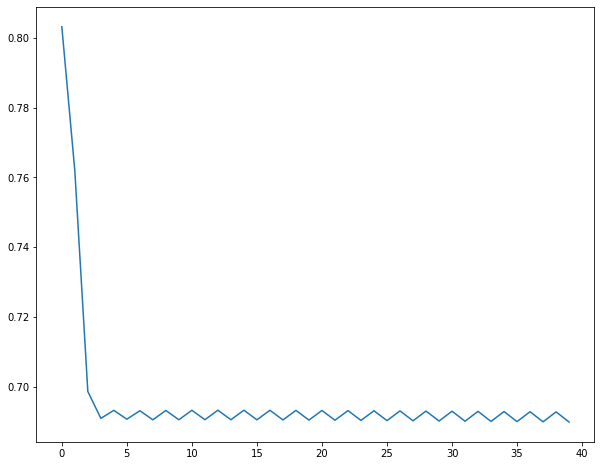

In [45]:
plt.plot(loss_res)

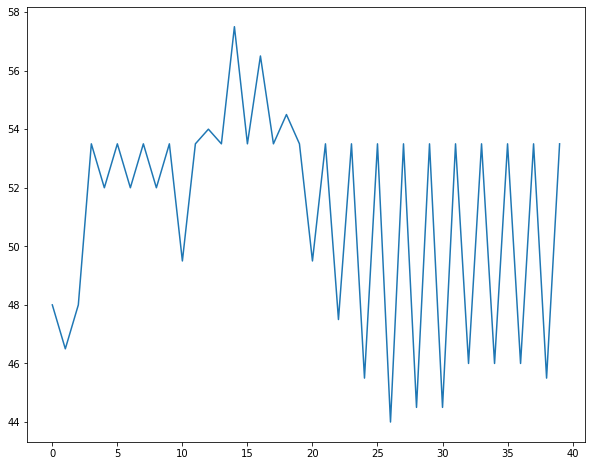

In [46]:
plt.plot(accuracy_res)

In [25]:
y_hat = model.predict(weights, X_test)

In [26]:
y_hat

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [27]:
y_test

array([0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0], dtype=int64)

In [28]:
correct = sum(y_test == y_hat)
incorrect = len(y_test) - correct
print("Correct: {}".format(correct))
print("Incorrect: {}".format(incorrect))
acc = correct/len(y_test)*100
print("Accuracy: {:2.2%}".format(correct/len(y_test)))
print("Acc ", acc)

Correct: 61
Incorrect: 39
Accuracy: 61.00%
Acc  61.0


# Exercises

DONE:
5. Extend the network to four layers. Experiment with the layer size. Adding another hidden layer means you will need to adjust both the forward propagation as well as the backpropagation code.
